In [144]:
import numpy as np
import pandas as pd

In [145]:
# india borders
NORTH = 37.1
SOUTH = 8.07
WEST = 68.12
EAST = 97.42

STEP = 0.01

def get_idx(lat, lon):
    return (int((NORTH - lat) / STEP), int((lon - WEST) / STEP))

num_lat_steps = int((NORTH - SOUTH) / STEP)
num_lon_steps = int((EAST - WEST) / STEP)

influence_map = np.zeros((num_lat_steps, num_lon_steps))

In [146]:
def exponential_decay(distance_squared):
    return np.exp(-6) * distance_squared**0.5

In [147]:
hospitals = pd.read_csv('hospital_dataset_cleaned.csv')
hospitals['Radius of Influence'] = hospitals['Effective Rating'] * 0.1

In [148]:
for i in range(len(hospitals)):
    lat, lon = hospitals.loc[i, 'Latitude'], hospitals.loc[i, 'Longitude']
    idx, jdx = get_idx(lat, lon)
    r = hospitals.loc[i, 'Radius of Influence']
    r_steps = int(r / STEP)

    # Define the bounding box for influence radius
    start_i = max(0, idx - r_steps)
    end_i = min(num_lat_steps, idx + r_steps + 1)
    start_j = max(0, jdx - r_steps)
    end_j = min(num_lon_steps, jdx + r_steps + 1)

    # Generate grid of indices within the bounding box
    x_coords, y_coords = np.meshgrid(np.arange(start_i, end_i), np.arange(start_j, end_j), indexing='ij')
    distance_squared = ((x_coords - idx) ** 2 + (y_coords - jdx) ** 2) * STEP**2

    # Apply influence decay only to points within the radius
    mask = distance_squared <= r**2
    influence_map[x_coords[mask], y_coords[mask]] += exponential_decay(distance_squared[mask])

In [149]:
influence_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

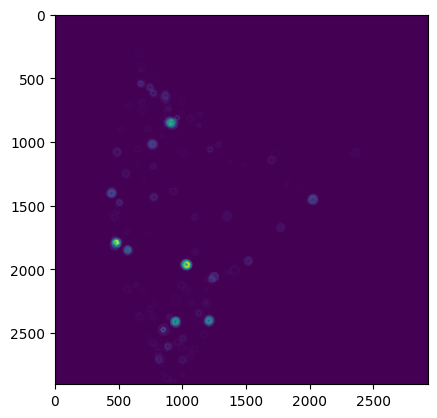

In [159]:
# plot influence map pixel by pixel
import matplotlib.pyplot as plt
plt.imshow(influence_map, cmap='gist_gray', interpolation='nearest')

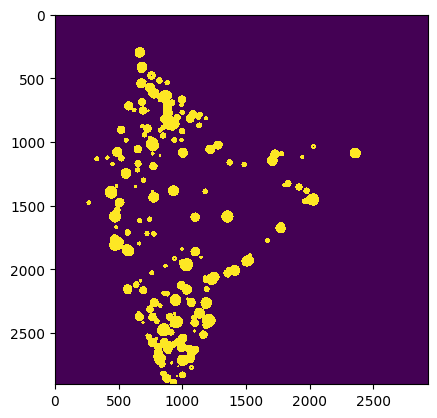

In [161]:
influence_map_ceil = np.ceil(influence_map)

plt.imshow(influence_map_ceil, cmap='viridis', interpolation='nearest')

In [162]:
# export numpy array 
np.save('influence_map.npy', influence_map)